In [561]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
import numpy as np
from scipy.spatial.distance import cdist
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import scipy.optimize as optim
from sklearn.metrics import confusion_matrix
pd.set_option("display.max_columns", None)

In [526]:
df = pd.read_csv("compas-scores-two-years.csv")

In [527]:
df.shape

(7214, 53)

In [528]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [529]:
nan_table = pd.DataFrame(df.isna().sum()).sort_values(by = 0, ascending=False)
nan_table.columns = ["count"]
nan_table[nan_table["count"]!=0].head()

,count
violent_recid,7214
vr_charge_degree,6395
vr_case_number,6395
vr_offense_date,6395
vr_charge_desc,6395


In [530]:
label = df["two_year_recid"]

In [531]:
from datetime import datetime

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

not_custody = df["in_custody"].isna()

custody_duration = [days_between(df["out_custody"][i],df["in_custody"][i]) if not not_custody[i] else 0 for i in range(df.shape[0])]

Text(0.5, 1.0, 'distribution of durations in custody')

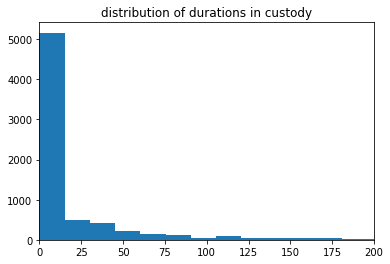

In [532]:
plt.hist(custody_duration,bins=400)
plt.xlim([0,200])
plt.title("distribution of durations in custody")

In [267]:
# violent_recid is classified into several levels
df[df["is_violent_recid"]==1]["vr_charge_degree"].unique()
df["vr_charge_degree"].unique()

array([nan, '(F3)', '(F2)', '(F1)', '(M1)', '(MO3)', '(M2)', '(F6)',
       '(F7)', '(F5)'], dtype=object)

In [268]:
def charge_degree(charge):
    if pd.isnull(charge):
        return 0
    elif charge == "(F1)":
        return 1
    elif charge == "(F2)":
        return 2
    elif charge == "(F3)":
        return 3
    elif charge == "(F5)":
        return 4
    elif charge == "(F6)":
        return 5
    elif charge == "(F7)":
        return 6
    elif charge == "(M1)":
        return 7
    elif charge == "(M2)":
        return 8
    elif charge == "(MO3)":
        return 9

In [269]:
vr_charge_degree = df["vr_charge_degree"].map(charge_degree)

In [533]:
filtered_df = df[["race","sex","age_cat","juv_fel_count","decile_score","juv_misd_count","juv_other_count","priors_count",
                 "c_charge_degree","decile_score.1","v_decile_score","priors_count.1"]]
filtered_df["custody_duration"] = custody_duration
#filtered_df["vr_charge_degree"] = vr_charge_degree

<ipython-input-533-21d7431d22dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["custody_duration"] = custody_duration


In [534]:
filtered_df.head()

,race,sex,age_cat,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_charge_degree,decile_score.1,v_decile_score,priors_count.1,custody_duration
0,Other,Male,Greater than 45,0,1,0,0,0,F,1,1,0,7
1,African-American,Male,25 - 45,0,3,0,0,0,F,3,1,0,10
2,African-American,Male,Less than 25,0,4,0,1,4,F,4,3,4,0
3,African-American,Male,Less than 25,0,8,1,0,1,F,8,6,1,0
4,Other,Male,25 - 45,0,1,0,0,2,F,1,1,2,0


In [536]:
filtered_df["race"].unique()

array(['Other', 'African-American', 'Caucasian', 'Hispanic',
       'Native American', 'Asian'], dtype=object)

In [538]:
categorical = filtered_df.dtypes == object
preprocess = make_column_transformer((OneHotEncoder(), categorical),(StandardScaler(),~categorical))

In [543]:
df = pd.DataFrame(preprocess.fit_transform(filtered_df))
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.141855,-1.228754,-0.187414,-0.218065,-0.711240,-1.228754,-1.072461,-0.711240,-0.190842
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-0.141855,-0.528522,-0.187414,-0.218065,-0.711240,-0.528522,-1.072461,-0.711240,-0.175282
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-0.141855,-0.178407,-0.187414,1.775750,0.108063,-0.178407,-0.275640,0.108063,-0.227149
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-0.141855,1.222057,1.873571,-0.218065,-0.506414,1.222057,0.919592,-0.506414,-0.227149
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-0.141855,-1.228754,-0.187414,-0.218065,-0.301588,-1.228754,-1.072461,-0.301588,-0.227149


In [558]:
caucasian = df.iloc[:,2] == 1
african = df.iloc[:,0] == 1

In [541]:
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=42)

## Baseline Classifier

In [559]:
clf1 = LogisticRegression()
clf1.fit(X_train,y_train)

LogisticRegression()

In [560]:
clf1.score(X_test,y_test)

0.6860706860706861

In [562]:
confusion_matrix(y_test, clf1.predict(X_test))

array([[626, 197],
       [256, 364]])

In [566]:
test_caucasian = X_test[:,2] == 1
test_african = X_test[:,0] == 1
caucasian_label = y_test[test_caucasian]
african_label = y_test[test_african]

In [569]:
caucasian_confusion = confusion_matrix(caucasian_label, clf1.predict(X_test[test_caucasian]))
caucasian_confusion

array([[268,  52],
       [ 96,  89]])

In [570]:
(caucasian_confusion[0,0]+caucasian_confusion[1,1])/np.sum(caucasian_confusion)

0.7069306930693069

In [571]:
african_confusion = confusion_matrix(african_label, clf1.predict(X_test[test_african]))
african_confusion

array([[241, 118],
       [114, 258]])

In [572]:
(african_confusion[0,0]+african_confusion[1,1])/np.sum(african_confusion)

0.6826265389876881

We could see that the calibration within the two groups are very close, but the false positive rate within African American is 34% and in Caucasion it's 26%, so there's a huge gap in this metric.

## Implementation of LFR

In [573]:
def lfr_loss(parameters_initialization, x_unprivileged, x_privileged, y_unprivileged, y_privileged, 
             num_prototype = 10, Ax=0.01, Ay=0.1, Az=0.5):
    
    w = parameters_initialization[:num_prototype]
    prototypes = parameters_initialization[num_prototype:].reshape(num_prototype,-1)
    num_unprivileged, n_features = x_unprivileged.shape
    num_privileged = x_privileged.shape[0]

    M_unprivileged, x_hat_unprivileged, y_hat_unprivileged = get_xhat_yhat(prototypes, w, x_unprivileged)
    M_privileged, x_hat_privileged, y_hat_privileged = get_xhat_yhat(prototypes, w, x_privileged)

    y_hat = np.concatenate([y_hat_unprivileged, y_hat_privileged], axis=0)
    y = np.concatenate([y_unprivileged.reshape((-1, 1)), y_privileged.reshape((-1, 1))], axis=0)
    
    
    Lx = np.mean((x_hat_unprivileged - x_unprivileged) ** 2) + np.mean((x_hat_privileged - x_privileged) ** 2)
    Ly = - np.mean(y * np.log(y_hat) + (1. - y) * np.log(1. - y_hat))
    Lz = np.mean(abs(np.mean(M_unprivileged, axis=0) - np.mean(M_privileged, axis=0)))

    total_loss = Ax*Lx + Ay*Ly + Az*Lz
    
    
    return total_loss

def get_xhat_yhat(prototypes, w, x):
    M = softmax(-cdist(x, prototypes), axis=1)
    x_hat = np.matmul(M, prototypes)
    y_hat = np.clip(
        np.matmul(M, w.reshape((-1, 1))),
        np.finfo(float).eps,
        1.0 - np.finfo(float).eps
    )
    return M, x_hat, y_hat

In [574]:
df.to_csv("temp.csv")

In [584]:
df = pd.read_csv("temp.csv").iloc[:,1:]

In [666]:
maxiter=15000
maxfun=5000
k = 25

Ax_list = [0.01, 0.1, 1]
Ay_list = [0.01, 0.1, 1]
Az_list = [0.5, 1]

In [627]:
X_train_beforeTransform, X_test_beforeTransform, y_train_beforeTransform, y_test_beforeTransform = train_test_split(df, label, test_size=0.2, random_state=42)

In [667]:
final_result = []

In [661]:
test_caucasian = X_test_beforeTransform.iloc[:,2] == 1
test_african = X_test_beforeTransform.iloc[:,0] == 1
caucasian_label = y_test[test_caucasian]
african_label = y_test[test_african]

In [668]:
t = 0
for Ax in Ax_list:
    for Ay in Ay_list:
        for Az in Az_list:
            num_train_samples, features_dim = np.shape(df)

            unprivileged_sample_ids = df.iloc[:,0]==1
            privileged_sample_ids = df.iloc[:,2]==1
            features_unprivileged = np.array(df[unprivileged_sample_ids])
            features_privileged = np.array(df[privileged_sample_ids])
            labels_unprivileged = np.array(label[unprivileged_sample_ids])
            labels_privileged = np.array(label[privileged_sample_ids])


            parameters_initialization = np.random.uniform(size=k + features_dim * k)
            bnd = [(0, 1)]*k + [(None, None)]*features_dim*k

            learned_model = optim.fmin_l_bfgs_b(lfr_loss, x0=parameters_initialization, epsilon=1e-5,
                                                          args=(features_unprivileged, features_privileged,
                                            labels_unprivileged, labels_privileged, k, Ax, Ay, Az),
                                                          bounds=bnd, approx_grad=True, maxfun=maxfun,
                                                          maxiter=maxiter)[0]
            w = learned_model[:k]
            prototypes = learned_model[k:].reshape((k, features_dim))

            threshold=0.5

            protected_attributes = np.array(df.iloc[:,:5]).reshape([-1, 1])
            unprivileged_sample_ids = np.array(df.iloc[:,0]==1)
            privileged_sample_ids = np.array(df.iloc[:,2]==1)
            features_unprivileged = np.array(df[unprivileged_sample_ids])
            features_privileged = np.array(df[privileged_sample_ids])
            labels_unprivileged = np.array(label[unprivileged_sample_ids])
            labels_privileged = np.array(label[privileged_sample_ids])

            _, features_hat_unprivileged, labels_hat_unprivileged = get_xhat_yhat(prototypes, w, features_unprivileged)

            _, features_hat_privileged, labels_hat_privileged = get_xhat_yhat(prototypes, w, features_privileged)

            transformed_features = np.zeros(shape=np.shape(df.iloc[:,6:]))
            transformed_labels = np.zeros(shape=np.shape(label))
            transformed_features[unprivileged_sample_ids] = features_hat_unprivileged[:,6:]
            transformed_features[privileged_sample_ids] = features_hat_privileged[:,6:]
            transformed_labels[unprivileged_sample_ids] = np.reshape(labels_hat_unprivileged, [-1, ])
            transformed_labels[privileged_sample_ids] = np.reshape(labels_hat_privileged,[-1, ])
            transformed_bin_labels = (np.array(transformed_labels) > threshold).astype(np.float64)
            transformed_features = pd.DataFrame(transformed_features)
            X_train,X_test,y_train,y_test = train_test_split(transformed_features,label,test_size=0.2, random_state=42)
            clf2 = LogisticRegression()
            clf2.fit(X_train,y_train)
            outcome = []
            outcome.append(clf2.score(X_test,y_test))
            caucasian_confusion = confusion_matrix(caucasian_label, clf2.predict(np.array(X_test[test_caucasian])))
            african_confusion = confusion_matrix(african_label, clf2.predict(np.array(X_test[test_african])))
            outcome.append(caucasian_confusion[1,0]/(caucasian_confusion[0,0]+caucasian_confusion[1,0]))
            outcome.append(caucasian_confusion[0,1]/(caucasian_confusion[1,1]+caucasian_confusion[0,1]))
            outcome.append((caucasian_confusion[0,0]+caucasian_confusion[1,1])/(np.sum(caucasian_confusion)))
            outcome.append(african_confusion[1,0]/(african_confusion[0,0]+african_confusion[1,0]))
            outcome.append(african_confusion[0,1]/(african_confusion[1,1]+african_confusion[0,1]))
            outcome.append((african_confusion[0,0]+african_confusion[1,1])/(np.sum(african_confusion)))

            name = "transformed" + str(t) + ".csv"
            transformed_features.to_csv(name)
            t += 1
            final_result.append(outcome)

/Users/leviqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/leviqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [684]:
result = pd.DataFrame(final_result)
result.columns = ["accuracy","caucasian FN rate","caucasian FP rate", "caucasian accuracy","african FN rate", "african FP rate", "african accuracy"]

In [685]:
result

,accuracy,caucasian FN rate,caucasian FP rate,caucasian accuracy,african FN rate,african FP rate,african accuracy
0,0.682606,0.249267,0.390244,0.704950,0.361179,0.305556,0.663475
1,0.674290,0.267218,0.380282,0.700990,0.388769,0.283582,0.649795
2,0.686764,0.252941,0.400000,0.699010,0.332418,0.316076,0.675787
3,0.689536,0.242991,0.418478,0.693069,0.319328,0.310160,0.685363
4,0.690922,0.251412,0.364238,0.714851,0.315951,0.335802,0.673051
5,0.696466,0.252841,0.372549,0.710891,0.308824,0.317136,0.686731
6,0.696466,0.256831,0.345324,0.718812,0.323034,0.314667,0.681259
7,0.688150,0.255618,0.369128,0.710891,0.325444,0.333333,0.670315
8,0.695773,0.253482,0.356164,0.716832,0.316860,0.320413,0.681259
9,0.695080,0.244898,0.376543,0.712871,0.313783,0.320513,0.682627


In [647]:
african_confusion = confusion_matrix(african_label, clf2.predict(np.array(X_test[test_african])))

In [671]:
import matplotlib.pyplot as plt

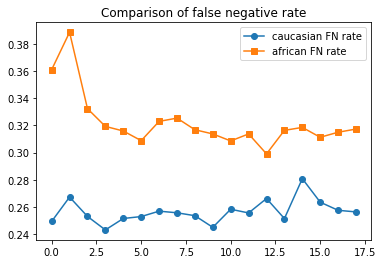

In [689]:
plt.plot(range(18),result["caucasian FN rate"],'o-', label = "caucasian FN rate")
plt.plot(range(18),result["african FN rate"], 's-', label = "african FN rate")
plt.title("Comparison of false negative rate")
plt.legend(loc = "upper right")

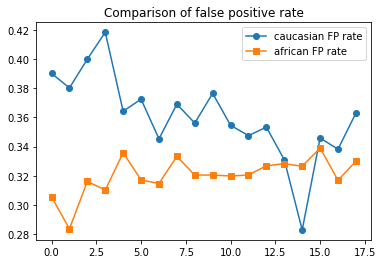

In [690]:
plt.plot(range(18),result["caucasian FP rate"],'o-', label = "caucasian FP rate")
plt.plot(range(18),result["african FP rate"], 's-', label = "african FP rate")
plt.title("Comparison of false positive rate")
plt.legend(loc = "upper right")

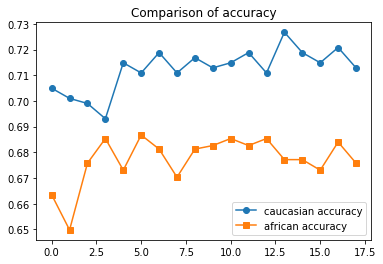

In [692]:
plt.plot(range(18),result["caucasian accuracy"],'o-', label = "caucasian accuracy")
plt.plot(range(18),result["african accuracy"], 's-', label = "african accuracy")
plt.title("Comparison of accuracy")
plt.legend(loc = "lower right")